Data ist from https://data.stadt-zuerich.ch/dataset/vbz-fahrzeiten-ogd . I used `head -n 1000000 fahrzeitensollist2017070220170708.csv > small.csv` to make a subset to start with.

We try different models to predict waiting time for a specific station (Goldbrunnenplatz) and line (tram 9) when time of day is given.

Since we are doing prediction rather than classical statistics, I decided to work with the package `scikit-learn` and not with `statsmodels`, even if `statsmodels` may be better for regressions.

In [1]:
%matplotlib inline
import numpy

from datetime import datetime

import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

# Make plots reproducible
numpy.random.seed(0)

# Not necessary, but I like the ggplot style better
plt.style.use('ggplot') 

# Read csv to dataframe
df = pd.read_csv('small.csv')
df_hpunkt = pd.read_csv('haltepunkt.csv')
df_hstelle = pd.read_csv('haltestelle.csv')

Let's get the row of the station and line.

In [2]:
halt_id = df_hstelle[df_hstelle['halt_lang'] == 'Zürich, Goldbrunnenplatz']['halt_id'].item()
linie = 9
print(df[(df['halt_id_von'] == halt_id) & (df['linie'] == linie)].head())

       linie  richtung betriebsdatum  fahrzeug  kurs  seq_von  halt_diva_von  \
25910      9         2      02.07.17      3045     9        4           1012   
25924      9         1      02.07.17      2087     6       30           1012   
25978      9         1      02.07.17      3054     7       30           1012   
26002      9         1      02.07.17      3045     9       30           1012   
26061      9         2      02.07.17      3054     7        4           1012   

       halt_punkt_diva_von halt_kurz_von1 datum_von         ...          \
25910                    1           GOLP  02.07.17         ...           
25924                    0           GOLP  02.07.17         ...           
25978                    0           GOLP  02.07.17         ...           
26002                    0           GOLP  02.07.17         ...           
26061                    1           GOLP  02.07.17         ...           

       fahrweg_id  fw_no  fw_typ  fw_kurz      fw_lang  umlauf_von  

## Multiple linear regression
First let's just do something "interesting":
1. We take continuous variables as independent variables.
2. We put them into a regression to predict delays. This gives a regression model.
3. Then we drop the insignificant variables from the model and rerun it. Let's see what r^2 we get.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Coefficients: 
 [ -5.41646253e-05  -5.77932485e+00  -1.50457330e-08]
Mean squared error: 2666.98
Variance score: -0.01


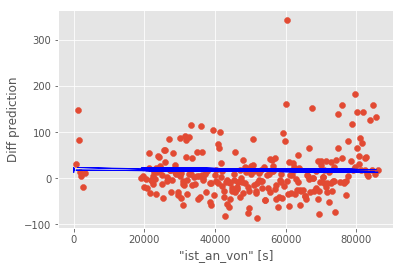

In [3]:
from sklearn import linear_model

def getHour(seconds):
    """Returns the hour, not rounded.
    
    seconds: of the day
    """
    hour = (seconds/3600)
    return hour

data_x = []
data_y = []
for index, row in df[(df['halt_id_von'] == halt_id) & (df['linie'] == linie)].iterrows():
    # It may cause problems that "richtung" has discrete values
    # Please consider that "ist_an_von" and getHour are basically the same
    d = [row['ist_an_von'], row['richtung'], getHour(row['ist_an_von'])]
    data_x.append(d)
    
    diff = row['ist_an_von'] - row['soll_an_von']
    data_y.append(diff)

# Convert to numpy array
data_x = numpy.array(data_x)#.reshape(len(data_x), 1)
data_y = numpy.array(data_y)
    
# Split data into training and test set
length = len(data_x)
data_x_train = data_x[:-int(length*1/5)]
data_x_test = data_x[-(length-len(data_x_train)):]

data_y_train = data_y[:-int(length*1/5)]
data_y_test = data_y[-(length-len(data_y_train)):]

# Create the model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_x_train, data_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % numpy.mean((regr.predict(data_x_test) - data_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(data_x_test, data_y_test))

# Plot outputs
plt.scatter(data_x_test[:, 0], data_y_test)
plt.plot(data_x_test, regr.predict(data_x_test), color='b', linewidth=1)

plt.xlabel('"ist_an_von" [s]')
plt.ylabel('Diff prediction')
plt.show()

The model is not able to predict anything from the given data.